In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# colour map for pie chart
from matplotlib import cm

import seaborn as sns

plt.style.use('seaborn')
from scipy import stats

In [6]:
# Make figure size larger

plt.rcParams.update({'figure.figsize': (10, 4)})

# Factors that influence dog breed choice
## Exploring animal intake and outcome of Animal Services; NYC dog license database 
### Author: AnaStasiaS-S



### Summary 

The main purpose of this project is to find out which factors influence people's choices of dog breed. We will look into different types of factors such as breed popularity and intelligence level, dog size, etc. Along with this we will find out the main reasons of pets abandonment in Animal Services and outcome types from Animal Services. A part of the research will be dedicated to dog adoption, which will help to find out which are the most preferable dogs by people.



### Introduction

For the purposes of this research I took a dataset of [Louisville (KY, USA) Metro Open Data service](https://data.louisvilleky.gov/dataset/animal-service-intake-and-outcome) which provides data for the care and control of animals in the Louisville Metro area, USA. The dataset includes a list of all instances of animals brought into Animal Services with outcomes. 

We will read the data from csv file, clean it and make some exploratory data analysis. Afterwards we will see how popular and intelligent are the dogs accommodated in Animal Services. For this we will take another two datasets:
* [Dog intelligence](https://data.world/len/intelligence-of-dogs), based on research by Stanley Coren, a professor of canine psychology at the University of British Columbia.
* [Breed popularity through years](https://www.akc.org/most-popular-breeds/), provided by American Kennel Club

And finally we will take [NYC Dog Licensing Dataset](https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp) to compare it with Animal services dataset. 



# Exploring Animal services dataset


#### Data dictionary:

* Animal ID - A generated unique identification when an animal's information is stored in the Chameleon Data Base
* Animal Type - Type of animal
* Intake Date - The date that the animal arrives at Metro Animal Services
* Intake Type - The reason the animal is at Metro Animal Services
* Intake Subtype - A secondary but more in depth reason why the animal is at Metro Animal Services
* Primary Color - The color that is most prevalent in the animal
* Primary Breed - The breed of the animal or the breed the animal looks like the most
* Secondary Breed - The other breed that the animal looks like
* Gender - Sex of the animal
* Secondary Color - A further description of the animal's color
* DOB - The date of birth of the animal or an estimated date of birth
* Intake Reason - The primary reason the animal is at Metro Animal Services
* Outcome Date - The date the outcome is entered if no outcome date is available the animal is still in the shelter
* Outcome Type - The type of outcome for the animal that can include returned to owner, adoption, sent to a rescue, etc.
* Outcome Subtype - A secondary, more in depth definition of the outcome type (ex. Transfer, rescue group vs. Transfer, KHS)

### Reading the data 

In [7]:
animals_data = pd.read_csv("animal-service-intake-and-outcome.csv")
animals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150842 entries, 0 to 150841
Data columns (total 22 columns):
AnimalID                       150842 non-null object
AnimalType                     150842 non-null object
IntakeDate                     150842 non-null object
IntakeType                     150842 non-null object
IntakeSubtype                  146286 non-null object
PrimaryColor                   150825 non-null object
PrimaryBreed                   150842 non-null object
SecondaryBreed                 40532 non-null object
Gender                         150842 non-null object
SecondaryColor                 80579 non-null object
DOB                            94618 non-null object
IntakeReason                   34805 non-null object
IntakeInternalStatus           150842 non-null object
IntakeAsilomarStatus           150842 non-null object
ReproductiveStatusAtIntake     150842 non-null object
OutcomeDate                    150640 non-null object
OutcomeType                  

We will keep only columns and values needed for the purposes of this project. For example we are not interested in information about `Animal ID`, `SecondaryBreed`, `SecondaryColor`, etc. We will consider `PrimaryBreed` as the only breed the animal has and `PrimaryColor` as the main color. Also let's make column names more "pythonic" and remove NaT values from `outcome_date` column.

In [8]:
# select columns

animals_data = animals_data[[
    'AnimalType', 
    'IntakeDate', 
    'IntakeType', 
    'PrimaryColor', 
    'PrimaryBreed', 
    'Gender',
    'DOB',
    'IntakeReason',
    'IntakeAsilomarStatus',
    'OutcomeDate',
    'OutcomeType',
    'OutcomeSubtype',
    'OutcomeAsilomarStatus'    
]]

In [9]:
# rename columns

animals_data.columns = [
    "animal_type",
    "intake_date",
    "intake_type",
    "color",
    "breed",
    "gender",
    "birth_date",
    "intake_reason",
    "intake_health_status",
    "outcome_date",
    "outcome_type", 
    "outcome_subtype", 
    "outcome_health_status",
]

In [10]:
# remove NaT values as there are a very few of them

animals_data = animals_data.dropna(subset=['outcome_date'])

In [11]:
animals_data.head()

,animal_type,intake_date,intake_type,color,breed,gender,birth_date,intake_reason,intake_health_status,outcome_date,outcome_type,outcome_subtype,outcome_health_status
0,CAT,2008-11-07 10:50:00,STRAY,WHITE,DOMESTIC SHORTHAIR,NEUTERED MALE,NaN,NaN,HEALTHY,2008-11-12 15:46:00,EUTH,FERAL,UNHEALTHY/UNTREATABLE
1,CAT,2008-11-10 10:20:00,STRAY,BLACK,DOMESTIC SHORTHAIR,UNKNOWN,NaN,STRAY,HEALTHY,2008-11-19 20:10:00,EUTH,CONTAG DIS,HEALTHY
2,BIRD,2014-07-23 23:21:00,CONFISCATE,RED,CHICKEN,MALE,NaN,NaN,HEALTHY,2014-11-05 15:49:00,TRANSFER,NaN,HEALTHY
3,OTHER,2014-07-24 18:29:00,ET REQUEST,BROWN,BAT,UNKNOWN,NaN,NaN,HEALTHY,2014-07-24 23:59:00,EUTH,MEDICAL,HEALTHY
4,DOG,2006-09-11 18:10:00,OWNER SUR,WHITE,PIT BULL TERRIER,MALE,2005-09-11 00:00:00,NO TIME,HEALTHY,2006-09-12 13:44:00,EUTH,TIME/SPACE,HEALTHY


Almost all the columns of the dataset have datatype $object$. That's why the next step will be to update data type where needed. We will convert  `itake_date` and `outcome_date` to $datetime$ type and take only the date part from it as we do not need minutes. 

In [12]:
animals_data.intake_date = pd.to_datetime(animals_data.intake_date).dt.date
animals_data.intake_date = pd.to_datetime(animals_data.intake_date)
animals_data.outcome_date = pd.to_datetime(animals_data.outcome_date).dt.date
animals_data.outcome_date = pd.to_datetime(animals_data.outcome_date)

### For which years we have the data?

In [13]:
# filter by intake date

animals_data.groupby(animals_data.intake_date.dt.year).size()

intake_date
2001        1
2002        1
2003        1
2004        3
2005     8410
2006    13949
2007    14813
2008    15722
2009    15283
2010    14341
2011    11974
2012    10509
2013    10631
2014     9347
2015     8717
2016     8274
2017     8628
2018       36
dtype: int64

In [14]:
# filter by outcome date

animals_data.groupby(animals_data.outcome_date.dt.year).size()

outcome_date
1950        1
1960        1
1970        2
2002        2
2003        3
2004        1
2005     8106
2006    13913
2007    14804
2008    15647
2009    15160
2010    14366
2011    12082
2012    10579
2013    10656
2014     9396
2015     8537
2016     8405
2017     8888
2018       91
dtype: int64

The first thing we see here is that intake and outcome number are very similar through the years.

The numbers before 2005 and after 2018 years are very low, probably collecting and/or recording the data began from 2005 onwards and for 2018 year data is not full. We will exclude these "incomplete" years from the dataset.

In [15]:
animals_data = animals_data[(animals_data.intake_date.dt.year >= 2005) & (animals_data.intake_date.dt.year <= 2017) & (animals_data.outcome_date.dt.year >= 2005) & (animals_data.outcome_date.dt.year <= 2017)]
intakes_by_year = animals_data.groupby(animals_data.intake_date.dt.year).size()
outcomes_by_year = animals_data.groupby(animals_data.outcome_date.dt.year).size()

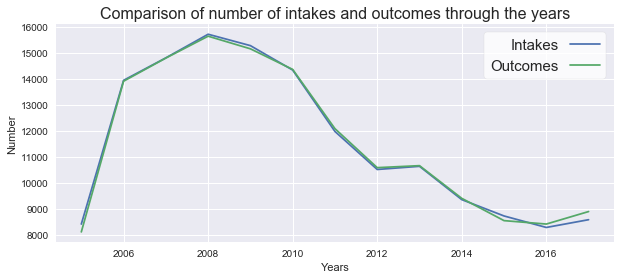

In [16]:
plt.plot(intakes_by_year, '-', label = 'Intakes')
plt.plot(outcomes_by_year, '-', label = 'Outcomes')
plt.legend(fontsize=15, markerfirst = False, frameon = True, facecolor = "White")
plt.title("Comparison of number of intakes and outcomes through the years", {'fontsize': 16})
plt.ylabel("Number")
plt.xlabel("Years")
plt.show()

Now the dataset is more or less cleaned and looks like the following:

In [17]:
animals_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150533 entries, 0 to 150841
Data columns (total 13 columns):
animal_type              150533 non-null object
intake_date              150533 non-null datetime64[ns]
intake_type              150533 non-null object
color                    150516 non-null object
breed                    150533 non-null object
gender                   150533 non-null object
birth_date               94338 non-null object
intake_reason            34511 non-null object
intake_health_status     150533 non-null object
outcome_date             150533 non-null datetime64[ns]
outcome_type             150272 non-null object
outcome_subtype          123760 non-null object
outcome_health_status    150533 non-null object
dtypes: datetime64[ns](2), object(11)
memory usage: 9.8+ MB


As we see, the data set includes 150533 entries of pet characteristics and the reasons of their intake and outcome. First of all it will be interesting to see what species come to Animal Services and for what reason. 

### Reasons for animal intake

First, we will examine the intake reasons. For this the data will be grouped by intake type and presented using bar chart. 

We have two columns that hold this information : `intake_reason` and `intake_type`. We will look into both of them. The first one holds the primary reason of surrendering the animal to Metro Animal Services. 

In [18]:
def barh(dataset, group_column, chart_title, xlabel_title):
    categories = None
    chart_by_category = None
    '''
    Draw horizontal bar chart for first 15 grouped values of selected column
    
    Parameters:
    - dataset (DataFrame) 
    - group_column (str)
    - chart_title (str)
    - xlabel_title (str)
    
    Returns:
    horizontal bar chart
    '''
    categories = dataset.groupby(group_column).size()
    categories = categories.sort_values().tail(15)
    
    y_pos = np.arange(len(categories.index))
    chart_by_category = plt.barh(y_pos,categories)
    plt.xlabel(xlabel_title, fontsize=13)
    plt.yticks(y_pos, categories.index, fontsize=10)
    plt.title(chart_title, fontsize = 20)
    plt.show()

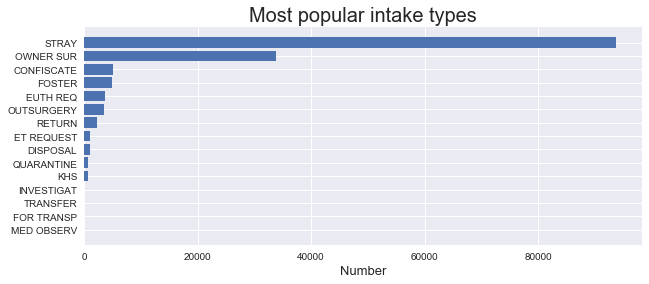

In [19]:
barh(animals_data, 'intake_type', 'Most popular intake types', 'Number')

In the above chart we see that the main intake types occurred to be **STRAY** and **OWNER SUR**render. Also, our data could be cleaned a little bit more, as for example group **EUTH REQ** in my opinion is the same as **ET REQUEST**, but we won't do this as the point of this data visualization is to see the most common types of animal intake.

Next, let's see why owners surrender animals to Animal Services:

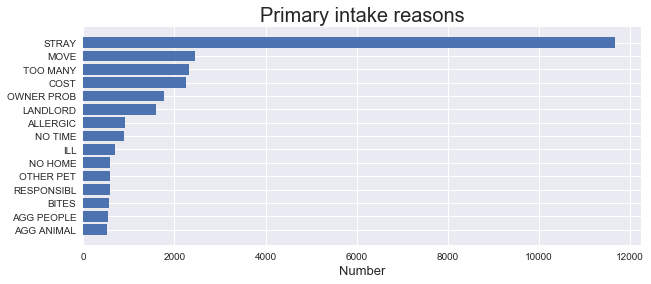

In [20]:
barh(animals_data, 'intake_reason', 'Primary intake reasons', 'Number')

The image above is super clear and gives a lot of information about the main reasons. 
We see that there is a number of **STRAY** animals which were saved from the streets but almost all the others reasons (about 75 in total) are about former pets which were abandoned by their owners for different kinds of reasons.

In [21]:
animals_data.intake_reason.unique()

array([nan, 'STRAY', 'NO TIME', 'TOO MANY', 'COST', 'ABANDON',
       'WONT ALLOW', 'HOUSE SOIL', 'FACILITY', 'UNKNOWN', 'ILL', 'MOVE',
       'ALLERGIC', 'RESPONSIBL', 'DOA', 'TOO OLD', 'ESCAPES', 'LANDLORD',
       'OWNER PROB', 'DIVORCE', 'INJURED', 'AGG PEOPLE', 'TOO YOUNG',
       'FOUND ANIM', 'AGG ANIMAL', 'VOCAL', 'BITES', 'EUTH BEHAV',
       'DESTRUC IN', 'EUTH OLD', 'NO HOME', 'FOSTER', 'CHASES PEO',
       'OTHER PET', 'ATTENTION', 'KILLS ANIM', 'NOFRIENDLY', 'EUTH ILL',
       'NEW BABY', 'BOX ODOR', 'DESTRUC OT', 'EUTH OTHER', 'GIFT',
       'OWNER DIED', 'SHEDS', 'HYPER', 'WRONG SPEC', 'REPORT',
       'CHILD PROB', 'FENCE', 'TOO BIG', 'AFRAID', 'DISOBIDIEN',
       'SURG PROB', 'CRUELTY', 'WILDLIFE', 'TOO SMALL', 'JUMPS UP',
       'WANTS OUT', 'EUTH YOUNG', 'COMPET ATT', 'VIOLATION', 'CHASES CAR',
       'DULL', 'TRAVEL', 'NO PROTECT', 'CHASES ANI', 'OWNER MED',
       'TRANSFER', 'PICA', 'WRONG SEX', 'ZONE', 'COPROPHAGY', 'UW ALTER',
       'AGG FEAR', 'PETMEDICAL', '

From the list above we see that there are reasons like **DULL**, **GIFT**, **COPROPHAGY** (whatever this means?), **TOO BIG**, **TOO SMALL**,.. Let's see how many of these animals had an owner by subtracting **STRAY**,**WILDLIFE** and **EUTH OLD** reasons.

In [22]:
former_domestic_persantage = round(animals_data[(animals_data.intake_reason != 'STRAY') & (animals_data.intake_reason != 'WILDLIFE') & (animals_data.intake_reason != 'EUTH OLD')].intake_reason.count()/animals_data.intake_reason.count()*100, 1)
print("The percentage of former domestic but abandoned animals is: {}%".format(former_domestic_persantage))

The percentage of former domestic but abandoned animals is: 65.0%


**AGG PEOPLE** category attracts my interest as I'm not sure what is included here (maybe aggressive to people?). But we can make a conclusion that there was a little bit fewer animal aggression to animals than to people.

### Which species were registered in Animal Services most of all?

The column `animal_type` holds this information. We will present it as a pie-chart.

In [23]:
def my_autopct(pct):
    '''
    Condition removal labels.
        
    Returns:
    - Floating-point number - labels the wedges with their numeric value
    '''
    return ('%1.1f%%' % pct) if pct > 1 else ''

In [24]:
def pie(dataset, group_column, chart_title):
    '''
    Plot a pie chart of array x.
    
    Parameters:
    - dataset (DataFrame)
    - group_column (str)
    - chart_title (str)
    
    Returns:
    A pie chart
    '''
    categories = None
    categories = dataset.groupby(group_column).size()
    categories = categories.sort_values(ascending = False)
    
    # use colour map do avoid repeating colours
    cs=cm.Set1(np.arange(9)/9.)
    plt.pie(categories, autopct=my_autopct, radius=1.00, pctdistance=0.50, textprops={'fontsize': 15}, 
        explode = (0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07), colors=cs) 
    # Makes the plot look circular
    plt.gca().set_aspect("equal")
    plt.title(chart_title, fontsize=20, loc="center")
    plt.legend(labels=categories.index, loc="center", bbox_to_anchor=(1.8, 0.5), prop={'size': 14})
    #plt.ticks().set_aspect("equal")
        
    plt.show()

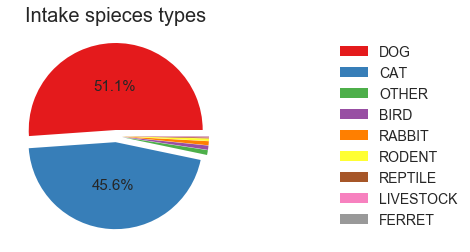

In [25]:
pie(animals_data, "animal_type", "Intake spieces types")

As expected most popular animals accommodating the Animal Services were cats and dogs.
### The evaluation of species number intake in time.
For this analysis, I will take only two columns  and represent them as a box chart with whiskers. This plot draws a box around the 25th and 75th percentiles of the data that captures the middle 50% of observations. A line is drawn at the 50th percentile (the median) and whiskers are drawn above and below the box to summarize the general extents of the observations. Dots are drawn for outliers outside the whiskers or extents of the data.

In [26]:
# create new dataset with 2 columns

intake_number_by_date = animals_data[['animal_type', 'intake_date']]

In [27]:
# group number of intakes by date

intake_number_by_date = intake_number_by_date.groupby(['intake_date']).size().reset_index()

In [28]:
# add new column for chart labels

intake_number_by_date['year'] = intake_number_by_date.intake_date.dt.year

Text(0.5, 0, 'Years')

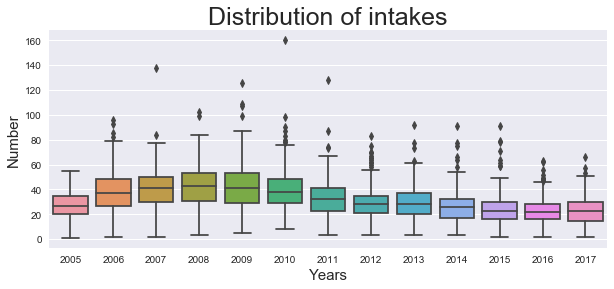

In [29]:
ax = sns.boxplot(data = intake_number_by_date, x='year',y=0)
ax.set_title("Distribution of intakes", fontsize=25)
ax.set_ylabel("Number", fontsize=15)
ax.set_xlabel("Years", fontsize=15)

This chart describes intake distribution through the years. We see the highest values of animal intakes in 2008 and 2009 where sometimes the numbers were really high, e.g. 160 species during one day in 2010. However, in most cases there were about 30 new animals registered per day. The good thing is that the tendency goes down through the years and after 2014 there were about 20 species registered per day.

### Animals outcome types

Now let's explore what we have as outcome.

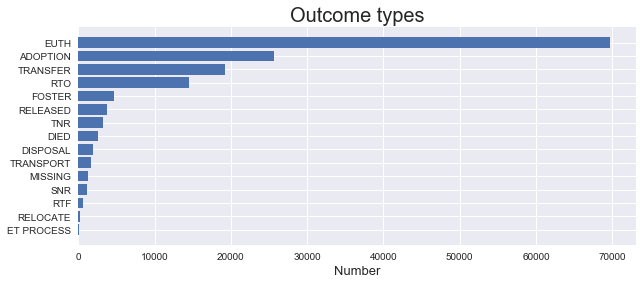

In [30]:
barh(animals_data, 'outcome_type', 'Outcome types', 'Number')

Unfortunately, as we can see, the most common way of leaving the Animal Services is **EUTH**anisation. Probably the euthanization number is correlated to the accommodation time because, from what I know from Animal Rescue channel programs, there is a time limit of 2 weeks for an animal to be adopted, otherwise it is euthanizated. 

**How long do animals stay in Animal Services?**

In [31]:
days_median = int((animals_data.outcome_date - animals_data.intake_date).dt.days.median())
days_mean = int((animals_data.outcome_date - animals_data.intake_date).dt.days.mean())
print("Median is {} days".format(days_median), "and the mean is {} days".format(days_mean))

Median is 6 days and the mean is 13 days


That means that 50% of animals stay in Animal Services less than 6 days and we can make a conclusion that the facility is looking not to keep animals for a long period of time.

Let's convert the column  `outcome_type` to boolean, where 1 will mean that animal was adopted and 0 - it left the Services in any other way. We will use these values later to explore the correlation with dog intelligence and breed popularity.

In [32]:
animals_data.outcome_type = animals_data.outcome_type.replace("ADOPTION", 1)
animals_data.outcome_type = pd.to_numeric(animals_data.outcome_type, errors='coerce').fillna(0).astype(int)
animals_data.groupby('outcome_type').size().sort_values()

outcome_type
1     25667
0    124866
dtype: int64

In the framework of this project we are going to compare the correlation between dog adoption, breed intelligence and popularity. We will create a new dataset containing only observations about dogs and will remove all columns which we are not going to use for the analysis (e.g. we do not need `animal_type` column as we look only into dogs data).

In [33]:
# take only dogs and delete unnecessary columns

dogs_dataset = animals_data[(animals_data.animal_type == "DOG")]
dogs_dataset = dogs_dataset[['breed', 'outcome_type', 'outcome_date', 'color', 'outcome_health_status']]

In [34]:
dogs_dataset.head()

,breed,outcome_type,outcome_date,color,outcome_health_status
4,PIT BULL TERRIER,0,2006-09-12,WHITE,HEALTHY
6,AMERICAN PIT BULL TERRIER,0,2005-12-08,BROWN,HEALTHY
8,LABRADOR RETRIEVER,0,2007-07-04,WHITE,HEALTHY
15,BEAGLE,0,2007-08-07,TRICOLOR,HEALTHY
17,PIT BULL TERRIER,0,2005-12-29,WHITE,HEALTHY


Now we will take two more datasets containing the information about dog intelligence and popularity and will merge them with our `dogs_dataset`. In order to have less Nan values let's rename some of the breeds in `dogs_dataset` to more appropriate names of these breeds so they match what we have in `breads_intelligence` and `breed_popularity` datasets.

In [35]:
dogs_dataset.breed.replace({
    'PIT BULL TERRIER': 'STAFFORDSHIRE BULL TERRIER', 
    'CHIHUAHUA - SMOOTH COATED': 'CHIHUAHUA',
    'AMERICAN PIT BULL TERRIER': 'AMERICAN STAFFORDSHIRE TERRIER',
    'JACK RUSS TER': 'JACK RUSSELL TERRIER',
    'POODLE - MINIATURE':'POODLE',
    'AMERICAN BULLDOG':'BULLDOG',
    'SCHNAUZER - MINIATURE':'MINIATURE SCHNAUZER',
    'PARSON (JACK) RUSSELL TERRIER':'JACK RUSSELL TERRIER',
    'ST BERNARD - SMOOTH COATED':'SAINT BERNARD',
    'ST BERNARD - ROUGH COATED':'SAINT BERNARD',
    'ALASKAN HUSKY':'SIBERIAN HUSKY',
    'POODLE - TOY':'POODLE',
    'FOX TERRIER - WIREHAIRED':'FOX TERRIER',
    'CHIHUAHUA - LONG HAIRED':'CHIHUAHUA',
    'WELSH CORGI - PEMBROKE':'PEMBROKE WELSH CORGI',
    'WELSH CORGI - CARDIGAN':'CARDIGAN WELSH CORGI',
    'ENGLISH BULLDOG':'BULLDOG',
    'COLLIE - ROUGH':'COLLIE',
    'COLLIE - SMOOTH':'COLLIE',
    'ALASKAN MALAMUTES':'SIBERIAN HUSKY',
    'DACHSHUND - WIREHAIRED':'DACHSHUND',
    'RAT TERRIER':'CESKY TERRIER',
    'ENGLISH POINTER':'POINTER',
    'BRUSSELS GRIFFON':'GRIFFON BRUXELLOIS',
    'TREEING WALKER COONHOUND':'BLACK AND TAN COONHOUND',
    'REDBONE COONHOUND':'BLACK AND TAN COONHOUND',
    'BLUETICK COONHOUND':'BLACK AND TAN COONHOUND',
    'SILKY TERRIER':'AUSTRALIAN SILKY TERRIER',
    'TOY FOX TERRIER':'FOX TERRIER (SMOOTH)',
    'FOX TERRIER':'FOX TERRIER (SMOOTH)',
    'CESKY TERRIER':'SCOTTISH TERRIER'
}, inplace = True)

## Dog intelligence data

We will take a [dataset of dog intelligence](https://data.world/len/intelligence-of-dogs). This dataset is based on research by Stanley Coren, a professor of canine psychology at the University of British Columbia. When Coren first published his book in 1994, there was a high degree of dispute of his analysis, though over time his work has been largely accepted. 

**Data Dictionary**

* Breed - breed name
* Classification - the main class of bread from "Brightest Dogs" down to "Obedience Intelligence"
* obey - probability that the breed obeys the first command (figure is lower bound)
* reps_lower - lower limit of repetitions to understand new commands
* reps_upper - upper limit of repetitions to understand new commands

In [36]:
breads_intelligence = pd.read_csv("dog_intelligence.csv")

In [37]:
breads_intelligence.head()

,Breed,Classification,obey,reps_lower,reps_upper
0,Border Collie,Brightest Dogs,95%,1,4
1,Poodle,Brightest Dogs,95%,1,4
2,German Shepherd,Brightest Dogs,95%,1,4
3,Golden Retriever,Brightest Dogs,95%,1,4
4,Doberman Pinscher,Brightest Dogs,95%,1,4


In [38]:
breads_intelligence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
Breed             136 non-null object
Classification    136 non-null object
obey              125 non-null object
reps_lower        136 non-null int64
reps_upper        136 non-null int64
dtypes: int64(2), object(3)
memory usage: 3.8+ KB


As we are only interested in Classification column, the rest will be dropped and Classification column will be converted to ranked categories from 0 to 5, where 0 - Brightest Dogs and 5 - Lowest Degree of Working/Obedience Intelligence.

In [39]:
# Rename columns

breads_intelligence.rename(columns={'Breed':'breed', 'Classification':'intelligence_rank'}, inplace=True)

In [40]:
# Rank the intelligence classification

breads_intelligence['breed'] = breads_intelligence['breed'].str.upper() 
breed_categories = breads_intelligence.intelligence_rank.unique()
breads_intelligence['intelligence_rank'] = breads_intelligence.intelligence_rank.astype("category", categories = breed_categories).cat.codes

c:\users\anastasiy.slavova\desktop\python37\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
# Remove unnecessary columns

breads_intelligence.drop(['obey', 'reps_lower', 'reps_upper'], axis = 1, inplace = True)
breads_intelligence.head()

,breed,intelligence_rank
0,BORDER COLLIE,0
1,POODLE,0
2,GERMAN SHEPHERD,0
3,GOLDEN RETRIEVER,0
4,DOBERMAN PINSCHER,0


## Breed popularity data per year

We will take the dog popularity dataset by [American Kennel Club](https://www.akc.org/most-popular-breeds/), which provides this information from 2013 onwards.

**Data Dictionary**

* Breed - breed name
* 2016 Rank - rank of the breed in 2016
* 2015 Rank - rank of the breed in 2015
* 2014 Rank - rank of the breed in 2014
* 2013 Rank - rank of the breed in 2013

In [42]:
breeds_popularity_data = pd.read_csv('AKC_Popular_Breeds_2013-2016.csv')
breeds_popularity_data.head()

,Breed,2016 Rank,2015 Rank,2014 Rank,2013 Rank
0,Retrievers (Labrador),1,1.0,1.0,1.0
1,German Shepherd Dogs,2,2.0,2.0,2.0
2,Retrievers (Golden),3,3.0,3.0,3.0
3,Bulldogs,4,4.0,4.0,5.0
4,Beagles,5,5.0,5.0,4.0


In [43]:
breeds_popularity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 5 columns):
Breed        189 non-null object
2016 Rank    189 non-null int64
2015 Rank    184 non-null float64
2014 Rank    184 non-null float64
2013 Rank    177 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.7+ KB


In [44]:
print("The average standard deviation for the breed ranks is {}.".format(round(breeds_popularity_data.std(axis = 1).mean()), 1))

The average standard deviation for the breed ranks is 5.0.


The mean deviation of breeds popularity is not very high, but in order to be more precise, we will only take popularity ranks for 2013 and will compare it with 2013 data of `dogs_dataset` because for this year we have the largest number of observations in the 2013-2016 year range.

We have about 180 ranks of breeds. For future analysis, we will split the range of ranks by some number for each rank (there are some Nan values for each year, we will drop them). So for example the most popular breeds will be those which take the first 20-22 places in the original ranking table. As a result we will have 8-9 ranked breed groups, where 0 - the most popular, 1 - the least popular category.

In addition, we will clean `popularity_dataset`: update column names, some breed names and select data by a chosen year. Furthermore, the breeds in `popularity_dataset` are written in plural form, so we will need to make them singular.

In [45]:
# Update and make breed names singular 

breeds_popularity_data.Breed = breeds_popularity_data.Breed.str.upper()
breeds_popularity_data.Breed.replace({
    'RETRIEVERS (LABRADOR)': 'LABRADOR RETRIEVER', 
    'RETRIEVERS (GOLDEN)': 'LABRADOR RETRIEVER',
    'RUSSELL TERRIERS': 'JACK RUSSELL TERRIER',
    'SIBERIAN HUSKIES': 'SIBERIAN HUSKY',
    'SPANIELS (COCKER)':'COCKER SPANIEL',
    'SPANIELS (ENGLISH SPRINGER)':'ENGLISH SPRINGER SPANIEL',
    'SPANIELS (ENGLISH COCKER)':'ENGLISH COCKER SPANIEL',
    'ST. BERNARDS':'SAINT BERNARDS',
    'BICHONS FRISES':'BICHON FRISE',
    'POINTERS (GERMAN SHORTHAIRED)':'GERMAN SHORTHAIRED POINTERS',
    'SETTERS (IRISH)':'IRISH SETTER',
    'SETTERS (ENGLISH)':'ENGLISH SETTER',
    'RETRIVERS (FLAT-COATED)':'FLAT-COATED RETRIEVER',
    'FOX TERRIERS (WIRE)':'FOX TERRIERS',
    'PEMBROKE WELSH CORGIS':'WELSH CORGIS',
    'DOGUES DE BORDEAUX':'DOGUE DE BORDEAUX',
    'KEESHONDEN':'KEESHOND',
    'CHINESE SHAR-PEI':'CHINESE SHARPEI'
}, inplace = True)
breeds_popularity_data.Breed = [x.rstrip('S') if x.endswith('S') else x for x in breeds_popularity_data.Breed]

For easy selection of data by year, the operation will be placed into function.

In [46]:
# Select ranks year and drop unnecessary columns and Nan rank values. 

def popularity_rank(dataset, year, quantile):
    '''
    Build dataset for year and ranks range

    Parameters:
    - dataset (DataFrame)
    - year (int)
    - quantile (int)
    
    Returns:
    Dataset with two columns: breed and year ranks.
    '''
    year_column = str(year) + " Rank"
    breeds_popularity = dataset[['Breed', year_column]]
    breeds_popularity = breeds_popularity.dropna(subset=[year_column])

    breeds_popularity['popularity_rank'] = pd.qcut(breeds_popularity[year_column], quantile, labels=False)

    breeds_popularity = breeds_popularity.rename(columns={'Breed':'breed'}) 

    breeds_popularity = breeds_popularity[['breed','popularity_rank']]
    return breeds_popularity

In [47]:
breeds_popularity = popularity_rank(breeds_popularity_data, 2013, 6)
breeds_popularity.groupby('popularity_rank').size()

popularity_rank
0    30
1    29
2    30
3    29
4    29
5    30
dtype: int64

Finally we get a dataset of breeds popularity grouped into 6 rank categories for 2013. 

A couple more steps will follow. As we said, we will take only the data for 2013 as the year with the most observations and will merge three datasets (`dogs_dataset`, `breeds_intelligence`, `breeds_popularity`) into one.

In [48]:
dogs_dataset = dogs_dataset[dogs_dataset.outcome_date.dt.year == 2013]
dogs_dataset = dogs_dataset.merge(breeds_popularity, on="breed", how='left')
dogs_dataset = dogs_dataset.merge(breads_intelligence, on="breed", how='left')
dogs_dataset.head()

,breed,outcome_type,outcome_date,color,outcome_health_status,popularity_rank,intelligence_rank
0,SAINT BERNARD,0,2013-12-28,WHITE,HEALTHY,1.0,4.0
1,STAFFORDSHIRE BULL TERRIER,0,2013-09-25,BROWN,HEALTHY,2.0,3.0
2,JACK RUSSELL TERRIER,0,2013-09-16,WHITE,HEALTHY,3.0,3.0
3,STAFFORDSHIRE BULL TERRIER,0,2013-11-26,BROWN,HEALTHY,2.0,3.0
4,STAFFORDSHIRE BULL TERRIER,0,2013-10-16,WHITE,HEALTHY,2.0,3.0


In [49]:
dogs_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5804 entries, 0 to 5803
Data columns (total 7 columns):
breed                    5804 non-null object
outcome_type             5804 non-null int32
outcome_date             5804 non-null datetime64[ns]
color                    5801 non-null object
outcome_health_status    5804 non-null object
popularity_rank          5599 non-null float64
intelligence_rank        5239 non-null float64
dtypes: datetime64[ns](1), float64(2), int32(1), object(3)
memory usage: 272.1+ KB


There are some NaN data for `intelligence_rank`, `popularity_rank`. These values will be removed in order to make the data as clean as possible and the rest will be presented as integers.

In [50]:
dogs_dataset = dogs_dataset.dropna(subset=['intelligence_rank', 'popularity_rank'])
dogs_dataset.popularity_rank = dogs_dataset.popularity_rank.astype(int)
dogs_dataset.intelligence_rank = dogs_dataset.intelligence_rank.astype(int)

What are the most popular breeds registered Animal Services?

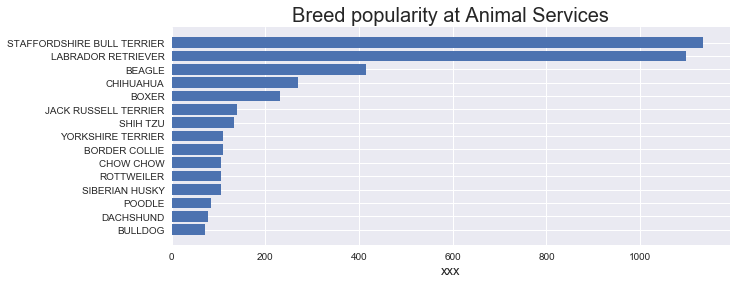

In [51]:
barh(dogs_dataset, 'breed', 'Breed popularity at Animal Services', 'xxx')

We see big size pets on first places in this chart (**STAFFORDSHIRE BULL TARRIER**, **LABRADOR RETRIEVER**), some medium sized (**BEAGLE**, **JACK RUSSEL**) and small ones (**CHIHUAHUA**, **SHIH TZU**). We can't say what the  most common dog size in the shelter. 


## Dog adoptions vs. breed intelligence

Is there any dependence between adoption and dog adoption and intelligence? We will perform Chi-squared Test using Python's Scipy library. The first step is to construct contingency table, its columns will be a boolean category if animal was adopted (0 - not adopted, 1 - adopted) and the rows - intelligence ranks (0 - brilliant dogs, 5 - dogs with lowest level of intelligence). Then we will visualize the result and will perform the Chi-squared test.

In [52]:
# construct a contingency table

adoption_vs_intelligence = pd.crosstab(dogs_dataset.outcome_type, dogs_dataset.intelligence_rank, margins = True)
adoption_vs_intelligence

intelligence_rank,0,1,2,3,4,5,All
outcome_type,,,,,,,
0,1168,172,223,1657,299,626,4145
1,306,42,78,251,136,192,1005
All,1474,214,301,1908,435,818,5150


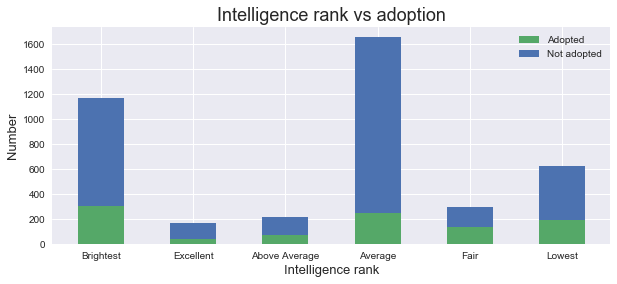

In [53]:
# plot bar chart

adopted_dogs = adoption_vs_intelligence.iloc[0][0:6].values
not_adopted_dogs = adoption_vs_intelligence.iloc[1][0:6].values

categories = ['Brightest', 'Excellent', 'Above Average', 'Average', 'Fair', 'Lowest']
adopted_chart = plt.bar(categories, adopted_dogs, 0.5)
not_adopted_chart = plt.bar(categories, not_adopted_dogs, 0.5)
plt.legend((not_adopted_chart[0], adopted_chart[0]), ('Adopted', 'Not adopted'))

plt.title('Intelligence rank vs adoption', fontsize = 18)
plt.xlabel('Intelligence rank', fontsize = 13)
plt.ylabel('Number', fontsize = 13)
plt.show()

The chart above visualizes `adoption_vs_intelligence` contingency table. It doesn't give us the answer whether there is any dependence between the two categories. Then we will perform the **Chi-square test**.

Our null hypothesis and the alternative hypothesis will be:

$H_0$ says there is no statistically significant relationship between dog adoption and the intelligence rank.

$H_1$ says opposite - there is a statistically significant relationship between dog adoption and the intelligence rank.

We assume that $H_0$ is true, therefore the differences between the two bar charts occur simply by chance. 
$p$ will be set to 1% (0.01). If we reject $H_0$, there will still be 1% chance that we rejected it wrongly.

In [54]:
stats.chi2_contingency(adoption_vs_intelligence)

(104.82557579952672,
 6.281151536799931e-17,
 12,
 array([[1186.35533981,  172.23883495,  242.26116505, 1535.66213592,
          350.11165049,  658.37087379, 4145.        ],
        [ 287.64466019,   41.76116505,   58.73883495,  372.33786408,
           84.88834951,  159.62912621, 1005.        ],
        [1474.        ,  214.        ,  301.        , 1908.        ,
          435.        ,  818.        , 5150.        ]]))

The $X2$ = 104,8, $p-value$ = ~0 and $DOF$ = 12. That means that there's a dependence between intelligence rank and adoption. Does it mean that people prefer to adopt smarter dogs? Definitely yes!


In our dataset we have much less adopted dogs from the total number of registered dogs in Animal Services. Most people adopted animals with rank 0 ('Brilliant dogs') and on the second place are breeds with 'Average' intelligence (rank 3).

What is the most common intelligent rank of the most adopted breed?

In [55]:
dogs_dataset.groupby(['outcome_type', 'breed', 'intelligence_rank']).outcome_type.count().sort_values(ascending = False).head(20)

outcome_type  breed                           intelligence_rank
0             STAFFORDSHIRE BULL TERRIER      3                    1061
              LABRADOR RETRIEVER              0                     886
              BEAGLE                          5                     315
1             LABRADOR RETRIEVER              0                     212
0             BOXER                           3                     193
              CHIHUAHUA                       4                     190
              JACK RUSSELL TERRIER            3                     108
1             BEAGLE                          5                     100
0             SIBERIAN HUSKY                  3                      94
              CHOW CHOW                       5                      92
              BORDER COLLIE                   0                      91
              YORKSHIRE TERRIER               2                      85
              ROTTWEILER                      0                      80


We got interesting result, it seems that **STAFFORDSHIRE BULL TERRIER** is the most commonly adopted breed in our dataset and its intelligence rank is "Average" (rank 3), the second place is for **LABRADOR RETRIEVER** and it is defined as one of the most intelligent breads (rank 0). Then maybe people liked these breed because Pit bulls were popular in 2013? 

## Dog adoption vs breed popularity

Now we will check if the adoption is linked to breed popularity, but this time we will build a chart containing only the Adopted category.

In [56]:
adoption_vs_popularity = pd.crosstab(dogs_dataset.outcome_type, dogs_dataset.popularity_rank)
adoption_vs_popularity

popularity_rank,0,1,2,3,4,5
outcome_type,,,,,,
0,2349,343,1291,148,5,9
1,702,117,132,38,4,12


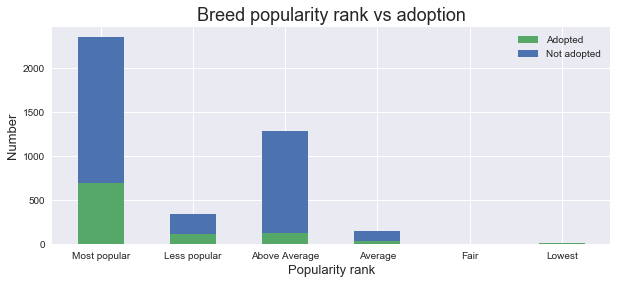

In [57]:
adopted_dogs = adoption_vs_popularity.iloc[0][0:6].values
not_adopted_dogs = adoption_vs_popularity.iloc[1][0:6].values

categories = ['Most popular', 'Less popular', 'Above Average', 'Average', 'Fair', 'Lowest']
adopted_chart = plt.bar(categories, adopted_dogs, 0.5)
not_adopted_chart = plt.bar(categories, not_adopted_dogs, 0.5)
plt.legend((not_adopted_chart[0], adopted_chart[0]), ('Adopted', 'Not adopted'))

plt.title('Breed popularity rank vs adoption', fontsize = 18)
plt.xlabel('Popularity rank', fontsize = 13)
plt.ylabel('Number', fontsize = 13)
plt.show()

So we have the most common adopted dogs of most popular breads in 2013. The chart clearly shows that the more popular the breed is, the bigger the chance for a dog of this breed to be adopted. We will take a look into this on a breed level.

In [58]:
dogs_dataset.groupby(['outcome_type', 'breed', 'intelligence_rank', 'popularity_rank']).size().sort_values(ascending = False).head(20)

outcome_type  breed                           intelligence_rank  popularity_rank
0             STAFFORDSHIRE BULL TERRIER      3                  2                  1061
              LABRADOR RETRIEVER              0                  0                   886
              BEAGLE                          5                  0                   315
1             LABRADOR RETRIEVER              0                  0                   212
0             BOXER                           3                  0                   193
              CHIHUAHUA                       4                  0                   190
              JACK RUSSELL TERRIER            3                  3                   108
1             BEAGLE                          5                  0                   100
0             SIBERIAN HUSKY                  3                  0                    94
              CHOW CHOW                       5                  2                    92
              BORDER COLLIE  

It turns out that the most commonly adopted dogs of popular breeds are **LABRADOR RETRIEVER**, **BEAGLE**, **CHIHUAHUA**, **STAFFORDSHIRE BULL TERRIER** and **SHIH TZU**. Almost all of them are included into most popular breeds list for 2013 (rank 0), the exception makes only **STAFFORDSHIRE BULL TERRIER** which has Average popularity (rank 2). Let's compare the breeds by the number of adopted to total number of registered dogs of every breed:

In [59]:
def coef_adopted(breed, sentence):
    '''
    calculates the persantage of adopted dogs from total by breed
    
    Parameters:
    breed (str)
    sentence (bool)
    
    Returns:
    number (float), persantage of adopted dogs
    '''
    coef_adopted = round(dogs_dataset[(dogs_dataset.breed == breed) & (dogs_dataset.outcome_type == 1)].breed.count()/dogs_dataset[(dogs_dataset.breed == breed)].breed.count()*100)       
    if sentence:
        return print("{}% of all registered species of the breed {} were adopted at 2013.".format(coef_adopted, breed))
    else:
        return coef_adopted

In [60]:
coef_adopted('LABRADOR RETRIEVER', 1)
coef_adopted('BEAGLE', 1)
coef_adopted('CHIHUAHUA', 1)
coef_adopted('BOXER', 1)
coef_adopted('STAFFORDSHIRE BULL TERRIER', 1)
coef_adopted('SHIH TZU', 1)

19.0% of all registered species of the breed LABRADOR RETRIEVER were adopted at 2013.
24.0% of all registered species of the breed BEAGLE were adopted at 2013.
30.0% of all registered species of the breed CHIHUAHUA were adopted at 2013.
17.0% of all registered species of the breed BOXER were adopted at 2013.
6.0% of all registered species of the breed STAFFORDSHIRE BULL TERRIER were adopted at 2013.
40.0% of all registered species of the breed SHIH TZU were adopted at 2013.


It seems that **LABRADOR RETRIEVER**, **BEAGLE**, **BOXER**, **SHIH TZU** have a bigger chance of adoption than **STAFFORDSHIRE BULL TERRIER**. As far as I know, **STAFFORDSHIRE BULL TERRIER** is a serious and difficult breed and is under special treatment in USA - the owner needs a special license to own this breed. It may be the main reason of the largest number of "not adopted" `outcome_type`. On the other hand, **LABRADOR RETRIEVER**, **BEAGLE**, **BOXER** are [the friendliest dogs](https://canna-pet.com/20-friendliest-dog-breeds/), especially **LABRADOR RETRIEVER**. The highest adoption rate has **SHIH TZU** - 40% of the total This breed is a cutie and maybe this is the main reason for the high adoption rate.

In the first part of the research we have proved that people are looking for **smart**, **popular** and **cuttie** breeds. We will explore another dataset for the same purpose.

# NYC Dog Licensing Dataset

Here is the dataset of [Dog Licensing in New York City, USA](https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp) for 2016, provided by Department of Health and Mental Hygiene (DOHMH), where owners can apply for and renew dog licenses. 

#### Data dictionary:

* RowNumber - Row number
* AnimalName - User-provided dog name (unless specified otherwise)
* AnimalGender - M (Male) or F (Female) dog gender
* AnimalBirthMonth - Month and year of dog's birth
* BreedName - The breed of the animal or the breed the animal looks like the most
* Borough, ZipCode, CommunityDistrict, CensusTract2010, NTA, CityCouncilDistrict, CongressionalDistrict, StateSenatorialDistrict - The detailed register address
* LicenseIssuedDate, LicenseExpiredDate - License issued and expire dates

In [61]:
nyc_dataset = pd.read_csv('nyc-dog-licensing-dataset.csv')

In [62]:
nyc_dataset.head()

,RowNumber,AnimalName,AnimalGender,AnimalBirthMonth,BreedName,Borough,ZipCode,CommunityDistrict,CensusTract2010,NTA,CityCouncilDistrict,CongressionalDistrict,StateSenatorialDistrict,LicenseIssuedDate,LicenseExpiredDate
0,1753,SHADOW,M,01/01/2000 12:00:00 AM,Beagle,Brooklyn,11236.0,318.0,1014.0,BK50,46.0,8.0,19.0,12/29/2014,01/30/2016
1,2415,ROCCO,M,10/01/2011 12:00:00 AM,Boxer,Brooklyn,11210.0,314.0,756.0,BK43,45.0,9.0,17.0,01/07/2015,01/30/2016
2,3328,LUIGI,M,09/01/2005 12:00:00 AM,Maltese,Bronx,10464.0,210.0,516.0,BX10,13.0,14.0,34.0,01/17/2015,02/02/2016
3,7537,PETUNIA,F,08/01/2013 12:00:00 AM,Pug,Brooklyn,11221.0,304.0,419.0,BK78,34.0,7.0,18.0,03/01/2015,03/28/2016
4,8487,ROMEO,M,10/01/2008 12:00:00 AM,Maltese,Bronx,10451.0,201.0,65.0,BX34,17.0,15.0,32.0,03/09/2015,03/09/2016


In [63]:
nyc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121949 entries, 0 to 121948
Data columns (total 15 columns):
RowNumber                  121949 non-null int64
AnimalName                 121714 non-null object
AnimalGender               121948 non-null object
AnimalBirthMonth           121948 non-null object
BreedName                  121948 non-null object
Borough                    121948 non-null object
ZipCode                    121948 non-null float64
CommunityDistrict          118612 non-null float64
CensusTract2010            118612 non-null float64
NTA                        118612 non-null object
CityCouncilDistrict        118612 non-null float64
CongressionalDistrict      118612 non-null float64
StateSenatorialDistrict    118612 non-null float64
LicenseIssuedDate          121948 non-null object
LicenseExpiredDate         121948 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 10.2+ MB


Will it be interesting to know what the most popular dog name is? In the previous dataset, we didn't have this information.

In [64]:
nyc_dataset.groupby('AnimalName').size().sort_values(ascending = False).head(20)

AnimalName
UNKNOWN              2467
NAME NOT PROVIDED    1764
BELLA                1008
MAX                  1001
CHARLIE               750
LOLA                  686
ROCKY                 668
COCO                  642
LUCY                  581
BUDDY                 559
LUCKY                 551
DAISY                 507
LUNA                  464
BAILEY                429
PRINCESS              428
CHLOE                 419
TEDDY                 417
TOBY                  415
MOLLY                 411
JACK                  351
dtype: int64

**BELLA** and **MAX** are the most popular dogs names in NYC for 2016!

We have a large amount of data for exploring. The dataset is almost full, but we have a small amount of NaN values that will ease the analysis. We are mostly interested in the `BreedName` column. We will explore it first and add intelligence and rank popularity to see if there will be any grouping differences compared to the previous dataset.

In [65]:
# rename column name and uppercase its values

nyc_dataset.rename(columns={'BreedName':'breed'}, inplace=True)
nyc_dataset.breed = nyc_dataset.breed.str.upper() 

In [66]:
# explore breed column

nyc_dataset[nyc_dataset.breed == "UNKNOWN"].count()

RowNumber                  16763
AnimalName                 16763
AnimalGender               16763
AnimalBirthMonth           16763
breed                      16763
Borough                    16763
ZipCode                    16763
CommunityDistrict          16322
CensusTract2010            16322
NTA                        16322
CityCouncilDistrict        16322
CongressionalDistrict      16322
StateSenatorialDistrict    16322
LicenseIssuedDate          16763
LicenseExpiredDate         16763
dtype: int64

In [67]:
nyc_dataset[nyc_dataset.breed.isna()]

,RowNumber,AnimalName,AnimalGender,AnimalBirthMonth,breed,Borough,ZipCode,CommunityDistrict,CensusTract2010,NTA,CityCouncilDistrict,CongressionalDistrict,StateSenatorialDistrict,LicenseIssuedDate,LicenseExpiredDate
51860,51790,BLU \tM\t10/01/2015\t1\tMaltese\tBronx\t10473\...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unfortunately, the dataset contains a lot of **UKNOWN** values in `breed` column and there is nothing to do about it except to drop this values. 

In [68]:
# take only rows with breed names known and non Nan values

nyc_dataset = nyc_dataset[nyc_dataset.breed != "UNKNOWN"]
nyc_dataset = nyc_dataset[nyc_dataset.RowNumber != 51790]

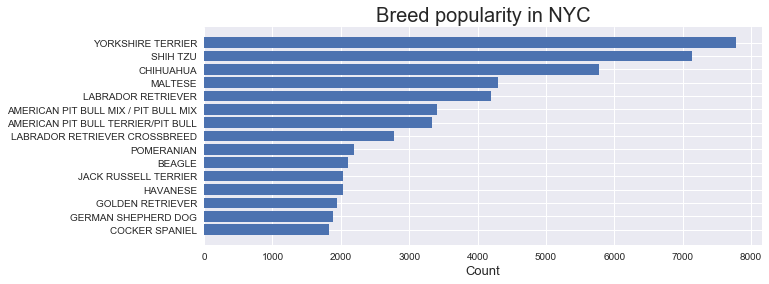

In [69]:
barh(nyc_dataset, 'breed', 'Breed popularity in NYC', 'Count')

The chart gives a lot of information. First of all, we see that the most common breeds have small sizes: **YORKSHIRE TERRIER**, **SHIH TZU**, **CHIHUAHUA**, **MALTESE**, followed by the top 2 breeds from the Animal Services dataset: **LABRADOR RETRIEVER**/ LABRADOR RETRIEVER CROSSBREED, **AMERICAN STAFFORSHIRE TERRIER** / AMERICAN PIT BULL MIX / AMERICAN PIT BULL TERRIER. 
As there are some crossbreeds but they have characteristics of primary breed, we will take mixes as primary breed and see what will happen.

In [70]:
# update some breed names

nyc_dataset.breed.replace({
    'LABRADOR RETRIEVER CROSSBREED': 'LABRADOR RETRIEVER',
    'GOLDEN RETRIEVER':'LABRADOR RETRIEVER',
    'AMERICAN PIT BULL MIX / PIT BULL MIX':'AMERICAN STAFFORDSHIRE TERRIER',
    'AMERICAN PIT BULL TERRIER/PIT BULL':'AMERICAN STAFFORDSHIRE TERRIER',
    'POODLE, STANDARD':'POODLE',
    'POODLE, MINIATURE':'POODLE',
    'DACHSHUND SMOOTH COAT MINIATURE':'DACHSHUND',
    'AKITA CROSSBREED':'AKITA',
    'BULL DOG, FRENCH':'FRENCH BULLDOG'
}, inplace = True)

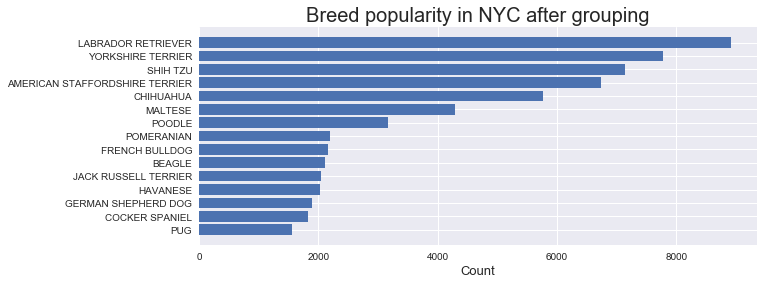

In [71]:
barh(nyc_dataset, 'breed', 'Breed popularity in NYC after grouping', 'Count')

Now the picture is different! **LABRADOR RETRIEVER** again takes the first place but **AMERICAN STAFFORDSHIRE TERRIER** is now on the 4th place. That definitely means that there is one more factor which influences people's choices - the **dogs size** (preferably **small**). 

For the purposes of this project we will take the first 10 most common breeds of NYC dataset and will look into their breed popularity and intelligence ranks.

In [72]:
# select top10 breeds

top_list = nyc_dataset.groupby('breed').size().sort_values(ascending = False).head(10).index
top_list

Index(['LABRADOR RETRIEVER', 'YORKSHIRE TERRIER', 'SHIH TZU',
       'AMERICAN STAFFORDSHIRE TERRIER', 'CHIHUAHUA', 'MALTESE', 'POODLE',
       'POMERANIAN', 'FRENCH BULLDOG', 'BEAGLE'],
      dtype='object', name='breed')

In [73]:
# select only rows with top10 breeds

nyc_dataset = nyc_dataset.loc[nyc_dataset['breed'].isin(top_list)]

In [74]:
nyc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50259 entries, 0 to 121947
Data columns (total 15 columns):
RowNumber                  50259 non-null int64
AnimalName                 50179 non-null object
AnimalGender               50259 non-null object
AnimalBirthMonth           50259 non-null object
breed                      50259 non-null object
Borough                    50259 non-null object
ZipCode                    50259 non-null float64
CommunityDistrict          48780 non-null float64
CensusTract2010            48780 non-null float64
NTA                        48780 non-null object
CityCouncilDistrict        48780 non-null float64
CongressionalDistrict      48780 non-null float64
StateSenatorialDistrict    48780 non-null float64
LicenseIssuedDate          50259 non-null object
LicenseExpiredDate         50259 non-null object
dtypes: float64(6), int64(1), object(8)
memory usage: 4.6+ MB


### Add popularity and intelligence ranks

Now we will take the popularity ranks for 2016 and will add them to `nyc_dataset`.

In [75]:
# select ranks for 2016 year from popularity dataset

breeds_popularity = popularity_rank(breeds_popularity_data, 2016, 6)
breeds_popularity.groupby('popularity_rank').size()

popularity_rank
0    32
1    31
2    32
3    31
4    31
5    32
dtype: int64

In [76]:
# add popularity and intelligence ranks 

nyc_dataset = nyc_dataset.merge(breeds_popularity, on="breed", how='left')
nyc_dataset = nyc_dataset.merge(breads_intelligence, on="breed", how='left')
nyc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59169 entries, 0 to 59168
Data columns (total 17 columns):
RowNumber                  59169 non-null int64
AnimalName                 59086 non-null object
AnimalGender               59169 non-null object
AnimalBirthMonth           59169 non-null object
breed                      59169 non-null object
Borough                    59169 non-null object
ZipCode                    59169 non-null float64
CommunityDistrict          57471 non-null float64
CensusTract2010            57471 non-null float64
NTA                        57471 non-null object
CityCouncilDistrict        57471 non-null float64
CongressionalDistrict      57471 non-null float64
StateSenatorialDistrict    57471 non-null float64
LicenseIssuedDate          59169 non-null object
LicenseExpiredDate         59169 non-null object
popularity_rank            59169 non-null int64
intelligence_rank          59169 non-null int8
dtypes: float64(6), int64(2), int8(1), object(8)
memory 

All breeds have got ranks of popularity (from 0 - most popular to 5 - least popular) and intelligence (from 0 - brightest to 5 - dummiest). In total, we have 59,169 observations. Does observation number (frequency) per breed equal breed popularity provided by AKC?

In [77]:
nyc_popularity_ranks = nyc_dataset.groupby(['popularity_rank', 'breed']).size().sort_values(ascending = False).reset_index()
nyc_popularity_ranks

,popularity_rank,breed,0
0,0,LABRADOR RETRIEVER,17820
1,0,YORKSHIRE TERRIER,7773
2,0,SHIH TZU,7141
3,2,AMERICAN STAFFORDSHIRE TERRIER,6742
4,0,CHIHUAHUA,5771
5,1,MALTESE,4292
6,0,POODLE,3169
7,0,POMERANIAN,2195
8,0,FRENCH BULLDOG,2160
9,0,BEAGLE,2106


In [78]:
print("Most dogs at NYC dataset have AKC popularity rank: {}".format(nyc_dataset.groupby(['popularity_rank']).size().reset_index().popularity_rank[0]))
print("Their percentage is: {}%".format(round(nyc_dataset.groupby(['popularity_rank']).size()[0]/nyc_dataset.groupby(['popularity_rank']).size().sum()*100, 1)))

Most dogs at NYC dataset have AKC popularity rank: 0
Their percentage is: 81.4%


In [79]:
nyc_popularity_ranks = nyc_dataset.groupby(['intelligence_rank', 'breed']).size().sort_values(ascending = False).reset_index()
nyc_popularity_ranks

,intelligence_rank,breed,0
0,0,LABRADOR RETRIEVER,17820
1,2,YORKSHIRE TERRIER,7773
2,5,SHIH TZU,7141
3,2,AMERICAN STAFFORDSHIRE TERRIER,6742
4,4,CHIHUAHUA,5771
5,4,MALTESE,4292
6,0,POODLE,3169
7,1,POMERANIAN,2195
8,4,FRENCH BULLDOG,2160
9,5,BEAGLE,2106


In [80]:
print("Most dogs at NYC dataset have intelligence rank: {}".format(nyc_dataset.groupby(['intelligence_rank']).size().reset_index().intelligence_rank[0]))
print("Their percentage is: {}%".format(round(nyc_dataset.groupby(['intelligence_rank']).size().max()/nyc_dataset.groupby(['intelligence_rank']).size().sum()*100, 1)))

Most dogs at NYC dataset have intelligence rank: 0
Their percentage is: 35.5%


# Conclusion

Finally, we can make a conclusion that most New Yorkers like **small**, **cuttie** and **intelligent** dogs! 
On the other hand, we see that there is a difference between the two datasets: in the first one we couldn't notice the tendency for dog size maybe because this dataset represents "extreme" situation, when the animals are being abandoned by their owners or found in the streets. Maybe it is much easier for people to take care of a small pet without contacting Animal Services and that's why the percentage of the most common breed in NYC Yorkshire terrier is NOT significant in Animal Services dataset. But in a normal situation (NYC license dataset, which represents a dog care of New Yorkers) we see that dog size matters! The common thing in both datasets is that **people do prefer intelligent dogs**! This way, they influence the evolution of Canis lupus familiaris, whose members will over time become smaller and more intelligent. However, this is another matter, which can be investigated in the framework of the next course.

Also, with a regret we can make a conclusion that there was a huge amount of irresponsible people, who surrender healthy pets to Animal Services for various reasons. The most common pets are dogs and cats, but there were some wild animals which were helped in difficult situations. We discovered that the most common outcome from Animal Services is euthanisation, while adoption takes the 2nd place in outcome popularity. It would be interesting to analyze this type of dataset sourced from Bulgaria but I haven't found any yet.


# Rerefencies

* [Loisville Animal Services](https://louisvilleky.gov/government/animal-services)
* [Are dog size and intelligence linked?](https://data.world/sharon/what-is-the-correlation-between-dog-size-and-intelligence), the inspiration
* [Ameriacan Kennel Club](https://www.akc.org/most-popular-breeds/)
* [The Intelligence of Dogs](https://en.m.wikipedia.org/wiki/The_Intelligence_of_Dogs#cite_ref-ReferenceA_18-0), a research by Stanley Coren, a professor of canine psychology 
* [NYC Open Data](https://data.cityofnewyork.us/Health/NYC-Dog-Licensing-Dataset/nu7n-tubp), free public data portal published by New York City agencies
* [CANNA PET](https://canna-pet.com/20-friendliest-dog-breeds/), 20 Friendliest Dog Breeds list
* [Chi-square test](https://lit-review.ru/biostatistika/kriterijj-khi-kvadrat-pirsona/)
* [Chi-Squared Test for Independence in Python](https://codingdisciple.com/chi-squared-python.html)
